In [1]:
from flowtorch.data import TAUSurfaceDataloader

Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


In [2]:
loader = TAUSurfaceDataloader("tau.para")

In [3]:
times = loader.write_times

In [4]:
times

['6.72265000e-01', '6.76940000e-01', '6.81615000e-01']

In [5]:
loader.vertices.shape[0]

1498849

In [6]:
loader.field_names[times[0]]

['global_id',
 'x',
 'y',
 'z',
 'pressure',
 'mean-p',
 'mean-cp',
 'stdev-p',
 'mean-cf',
 'mean-cfx',
 'mean-cfy',
 'mean-cfz',
 'cp',
 'cfx',
 'cfy',
 'cfz']

In [7]:
cp = loader.load_snapshot("cp", times)

In [8]:
x = loader.vertices[:,0]
y = loader.vertices[:,1]

In [9]:
cp[:,0].shape

torch.Size([1498849])

In [10]:
import matplotlib.pyplot as plt

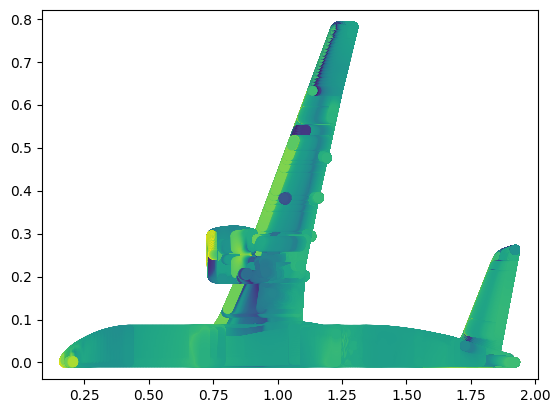

In [11]:
fig, ax = plt.subplots()
ax.scatter(x,y,c=cp[:,0])
plt.show()

In [12]:
from netCDF4 import Dataset

In [13]:
sfile = loader._file_name(times[0])

In [14]:
sdata = Dataset(sfile)

In [15]:
from os.path import join
mfile = join(loader._para.path, loader._para.config["primary_grid"])
mdata = Dataset(mfile)
mdata.variables

{'marker': <class 'netCDF4._netCDF4.Variable'>
 int32 marker(no_of_markers)
 unlimited dimensions: 
 current shape = (23,)
 filling on, default _FillValue of -2147483647 used,
 'points_of_tetraeders': <class 'netCDF4._netCDF4.Variable'>
 int32 points_of_tetraeders(no_of_tetraeders, points_per_tetraeder)
 unlimited dimensions: 
 current shape = (61547913, 4)
 filling on, default _FillValue of -2147483647 used,
 'points_of_prisms': <class 'netCDF4._netCDF4.Variable'>
 int32 points_of_prisms(no_of_prisms, points_per_prism)
 unlimited dimensions: 
 current shape = (4401478, 6)
 filling on, default _FillValue of -2147483647 used,
 'points_of_pyramids': <class 'netCDF4._netCDF4.Variable'>
 int32 points_of_pyramids(no_of_pyramids, points_per_pyramid)
 unlimited dimensions: 
 current shape = (1176525, 5)
 filling on, default _FillValue of -2147483647 used,
 'points_of_hexaeders': <class 'netCDF4._netCDF4.Variable'>
 int32 points_of_hexaeders(no_of_hexaeders, points_per_hexaeder)
 unlimited dim

In [16]:
mdata.variables["boundarymarker_of_surfaces"].shape

(2006951,)

In [17]:
mdata.variables["points_of_surfacetriangles"][:].shape

(207742, 3)

In [18]:
mdata.variables["points_of_surfacequadrilaterals"][:].shape

(1799209, 4)

In [19]:
import torch as pt
p_of_surftris = mdata.variables["points_of_surfacetriangles"][:].flatten()
pt.unique(pt.from_numpy(p_of_surftris)).shape

torch.Size([107488])

In [20]:
mdata.variables["points_xc"]

<class 'netCDF4._netCDF4.Variable'>
float64 points_xc(no_of_points)
unlimited dimensions: 
current shape = (135032533,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [21]:
sdata.variables["global_id"]

<class 'netCDF4._netCDF4.Variable'>
int32 global_id(no_of_points)
unlimited dimensions: 
current shape = (1498849,)
filling on, default _FillValue of -2147483647 used

# Prototyping

In [22]:
import numpy as np
import torch as pt
from netCDF4 import Dataset
from os.path import join

In [23]:
mfile = join(loader._para.path, loader._para.config["primary_grid"])
mdata = Dataset(mfile)

In [24]:
points_x = mdata.variables["points_xc"]
points_y = mdata.variables["points_yc"]
points_z = mdata.variables["points_zc"]
points_tri = mdata.variables["points_of_surfacetriangles"]
points_quad = mdata.variables["points_of_surfacequadrilaterals"]
marker_list = mdata.variables["boundarymarker_of_surfaces"]

In [25]:
"""
# Assuming you have the following lists
points_x = np.array([0.5, 0.2, 0.8, 0.6, 0.4, 0.7, 0.3, 0.9])
points_y = np.array([0.1, 0.4, 0.6, 0.9, 0.2, 0.5, 0.8, 0.3])
points_z = np.array([0.7, 0.3, 0.9, 0.4, 0.8, 0.5, 0.2, 0.6])
points_tri = [[0, 1, 2], [3, 4, 5], [6, 7, 0], [1, 3, 5]]
points_quad = [[0, 1, 2, 3], [4, 5, 6, 7]]
marker_list = [200, 200, 200, 400, 500, 200]
"""

# Combine x, y, z coordinates into a single array
points_xyz = np.column_stack((points_x, points_y, points_z))

# Create a dictionary to map unique points to their indices and markers
unique_points = {}
unique_markers = {}

# Iterate over triangle list and marker list
for triangle, marker in zip(points_tri, marker_list[:len(points_tri)]):
    points_triangle = points_xyz[triangle]
    for point in points_triangle:
        point_key = tuple(np.append(point,marker))
        if point_key not in unique_points:
            unique_points[point_key] = len(unique_points)
            unique_markers[point_key] = marker

# Iterate over quad list and marker list
for quad, marker in zip(points_quad, marker_list[len(points_tri):]):
    points_quad = points_xyz[quad]
    for point in points_quad:
        point_key = tuple(np.append(point,marker))
        if point_key not in unique_points:
            unique_points[point_key] = len(unique_points)
            unique_markers[point_key] = marker

# Create a new array to store unique points and markers
unique_array = np.zeros((len(unique_points), 4))  # Assuming 3D points and 1 marker value
unique_array[:, :] = np.array(list(unique_points.keys()))

# Remove duplicate points with same markers
_, unique_indices = np.unique(unique_array[:, :], axis=0, return_index=True)
unique_array = unique_array[unique_indices]

print(unique_array.shape)

(1916681, 4)


# Faster version

In [32]:
mfile = join(loader._para.path, loader._para.config["primary_grid"])
mdata = Dataset(mfile)
points_x = mdata.variables["points_xc"][:]
points_y = mdata.variables["points_yc"][:]
points_z = mdata.variables["points_zc"][:]
points_tri = mdata.variables["points_of_surfacetriangles"][:]
points_quad = mdata.variables["points_of_surfacequadrilaterals"][:]
marker_list = mdata.variables["boundarymarker_of_surfaces"][:]

In [35]:
import numpy as np

# Assuming you have the following lists
points_x = np.array([0.5, 0.2, 0.8, 0.6, 0.4, 0.7, 0.3, 0.9])
points_y = np.array([0.1, 0.4, 0.6, 0.9, 0.2, 0.5, 0.8, 0.3])
points_z = np.array([0.7, 0.3, 0.9, 0.4, 0.8, 0.5, 0.2, 0.6])
points_tri = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 0], [1, 3, 5]])
points_quad = np.array([[0, 1, 2, 3], [4, 5, 6, 7]])
marker_list = np.array([200, 200, 200, 400, 500, 200])

# Combine x, y, z coordinates into a single array
points_xyz = np.column_stack((points_x, points_y, points_z))

# Create a new array to store combined indices
num_triangles = len(points_tri)
num_quads = len(points_quad)
total_triangles = num_triangles + num_quads
points_indices = np.full((total_triangles, 4), -1, dtype=int)
points_indices[:num_triangles, :3] = points_tri
points_indices[num_triangles:, :] = points_quad

# Combine marker_list for triangle and quad
combined_marker_list = np.concatenate((marker_list[:num_triangles], marker_list[num_triangles:]))

# Create a structured array to store unique points and markers
dtype = [('x', float), ('y', float), ('z', float), ('marker', int)]
unique_points = []
unique_markers = []

# Iterate over indices and marker_list simultaneously
for indices, marker in zip(points_indices, combined_marker_list):
    indices = indices[indices != -1]  # Remove -1 values
    points = points_xyz[indices]
    unique_points.append(points)
    unique_markers.append(np.full(len(points), marker))

unique_points = np.concatenate(unique_points)
unique_markers = np.concatenate(unique_markers)

# Remove duplicate points with same markers
_, unique_indices = np.unique(np.column_stack((unique_points, unique_markers)), return_index=True)
unique_array = np.empty(len(unique_indices), dtype=dtype)
unique_array['x'] = unique_points[unique_indices, 0]
unique_array['y'] = unique_points[unique_indices, 1]
unique_array['z'] = unique_points[unique_indices, 2]
unique_array['marker'] = unique_markers[unique_indices]

print(unique_array)

IndexError: index 39 is out of bounds for axis 0 with size 20